In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['OMP_NUM_THREADS'] = '4'
# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']= 'platform'

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from functools import partial
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import blackjax
from flax.training import train_state
import optax
# sns.set(font_scale=2, style='whitegrid')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("pdf", "png")
plt.rcParams["savefig.dpi"] = 150
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = 6, 4
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["font.size"] = 16
plt.rcParams["lines.linewidth"] = 2.0
plt.rcParams["lines.markersize"] = 8
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.linewidth"] = 1.0
plt.rcParams["legend.facecolor"] = "white"
# plt.rcParams['grid.color'] = "grey"
plt.rcParams["text.usetex"] = True
# plt.rcParams['font.family'] = "normal"
# plt.rcParams['font.family'] = "sans-serif"
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams[
    "text.latex.preamble"
] = "\\usepackage{subdepth} \\usepackage{amsfonts} \\usepackage{type1cm}"

/tmp/ipykernel_454774/928529178.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("pdf", "png")


In [3]:
def snelson(x_train, y_train, n_test=500, x_test_lim=6, standardize_x=False, standardize_y=False):
    mask = ((x_train < 1.5) | (x_train > 3)).flatten()
    x_train = x_train[mask]
    y_train = y_train[mask]

    idx = np.argsort(x_train)
    x_train = x_train[idx]
    y_train = y_train[idx]

    if standardize_x:
        x_train = (x_train - x_train.mean(0)) / x_train.std(0)
    if standardize_y:
        y_train = (y_train - y_train.mean(0)) / y_train.std(0)

    x_test = np.linspace(-x_test_lim, x_test_lim, n_test)[:, None]

    return x_train[:, None], y_train[:, None], x_test

In [4]:
_raw_data = pd.read_csv('snelson.csv')
x_train, y_train = np.array(_raw_data.x.values), np.array(_raw_data.y.values)
x_train, y_train, x_test = snelson(x_train, y_train, standardize_x=True, standardize_y=True)

In [5]:
from flax import linen as nn

class MLP(nn.Module):
    out_size: int
    H: int = 100

    @nn.compact
    def __call__(self, x):
        out = nn.Sequential([
            nn.Dense(features=self.H),
            nn.tanh,
            nn.Dense(features=self.H),
            nn.tanh,
            nn.Dense(features=self.out_size),
        ])(x)
        return out

In [6]:
import distrax


def logprior_fn(params, prior_scale):
    leaves, _ = jax.tree_util.tree_flatten(params)
    flat_params = jnp.concatenate([jnp.ravel(p) for p in leaves])
    lik = distrax.Normal(0., prior_scale).log_prob(flat_params)
    return jnp.sum(lik)

def loglikelihood_fn(params, X, Y, model, noise_scale):
    f = model.apply(params, X)
    lik = distrax.Normal(f, noise_scale).log_prob(Y)
    return jnp.sum(lik)

def logprob_fn(params, X, Y, model, noise_scale, prior_scale):
    return loglikelihood_fn(params, X, Y, model, noise_scale) + logprior_fn(params, prior_scale)

def l2_loss_fn(params, X, Y, model, noise_scale, prior_scale):
    y_pred = model.apply(params, X)
    loss = jnp.sum((Y - y_pred)**2)
    leaves, _ = jax.tree_util.tree_flatten(params)
    reg = jnp.sum(jnp.array([jnp.sum(jnp.ravel(p)**2) for p in leaves]))
    lmbda = (noise_scale / prior_scale)**2
    return loss + lmbda * reg

def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

def get_predictions(model, samples, X):
    vmap = jax.vmap(model.apply, in_axes=(0, None), out_axes=0)
    predictions = vmap(samples, X)
    return predictions.squeeze(-1)

def get_hmc_samples(rng_key, logposterior_fn, model, n_warmup, num_samples, x_test):    
    rng_key, init_params_key = jax.random.split(rng_key)
    init_params = jax.jit(model.init)(init_params_key, jnp.ones((1, 1)))
    adapt = blackjax.window_adaptation(blackjax.nuts, logposterior_fn, n_warmup)
    rng_key, warmup_key = jax.random.split(rng_key)
    final_state, kernel, _ = adapt.run(warmup_key, init_params)
    rng_key, inference_key = jax.random.split(rng_key)
    states = inference_loop(inference_key, kernel, final_state, num_samples)
    samples = states.position
    y_pred_samples = get_predictions(model, samples, x_test)
    return y_pred_samples

def get_sgd_pred(lr, momentum, n_steps, rng_key, loss_fn, model, x_train, y_train, x_test):
    rng_key, init_params_key = jax.random.split(rng_key)
    init_params = jax.jit(model.init)(init_params_key, jnp.ones((1, 1)))
    tx = optax.sgd(lr, momentum=momentum)
    # tx = optax.adam(lr)
    ts = train_state.TrainState.create(apply_fn=model.apply, params=init_params, tx=tx)
    grad_fn = jax.value_and_grad(loss_fn)
    losses = []
    for e in tqdm(range(n_steps)):
        loss, grads = grad_fn(ts.params)
        ts = ts.apply_gradients(grads=grads)
        # y_pred = model.apply(ts.params, x_train)
        # loss = jnp.mean((y_train - y_pred)**2)
        losses.append(loss)
    return model.apply(ts.params, x_test)[..., 0], losses


In [7]:
def run_experiment(noise_scale, prior_scale, n_warmup, num_samples, lr, momentum, n_steps, plots_dir):
    # model
    model = MLP(out_size=1)
    logposterior_fn = partial(logprob_fn, X=x_train, Y=y_train, model=model, noise_scale=noise_scale, prior_scale=prior_scale)
    # HMC
    rng_key = jax.random.PRNGKey(42)
    y_hmc_samples = get_hmc_samples(rng_key, logposterior_fn, model, n_warmup, num_samples, x_test)

    # SGD
    rng_key = jax.random.PRNGKey(42)
    loss_fn = partial(l2_loss_fn, X=x_train, Y=y_train, model=model, noise_scale=noise_scale, prior_scale=prior_scale)
    y_sgd, losses = get_sgd_pred(lr, momentum, n_steps, rng_key, loss_fn, model, x_train, y_train, x_test)
    # plot and save losses
    plt.figure()
    plt.plot(losses)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.savefig(f'{plots_dir}/sgd_losses_n{noise_scale}_p{prior_scale}.png')
    plt.show()

    fig, ax = plt.subplots(figsize=(9, 6), dpi=120)
    ax.scatter(x_train, y_train, c='r', label='Train Data', s=10)

    ax.plot(x_test[..., 0], y_sgd, c='green', label='MAP (GD)')

    y_hmc_mean = np.mean(y_hmc_samples, axis=0)
    y_hmc_std = np.std(y_hmc_samples, axis=0)
    ax.plot(x_test[..., 0], y_hmc_mean, c='black', label='Posterior mean')
    ax.fill_between(x_test[..., 0], y_hmc_mean - 2 * y_hmc_std, y_hmc_mean + 2 * y_hmc_std, color="C0", alpha=0.2)

    # choose n_draws random y_hmc_samples
    n_draws = 100
    y_hmc_samples_viz = y_hmc_samples[jax.random.choice(rng_key, y_hmc_samples.shape[0], (n_draws,))]
    ax.plot(x_test[..., 0], y_hmc_samples_viz.T,
            linewidth=0.5,
            color="xkcd:blue",
            zorder=3,
            alpha=0.3)

    ax.set(xlabel='$x$', ylabel='$y$', ylim=[-3, 3])
    # add function draws to legend
    handles, labels = ax.get_legend_handles_labels()
    handles.append(plt.Line2D([0], [0], color='blue', linewidth=.5))
    labels.append('Posterior draws')
    ax.legend(handles, labels)

    ax.scatter(x_train, y_train, c='r', label='Train Data', s=10)
    ax.grid(True)

    # show noise_scale, prior_scale on plot
    ax.text(0.05, 0.95, f'Noise scale: {noise_scale}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.text(0.05, 0.9, f'Prior scale: {prior_scale}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

    fig.tight_layout()
    fig.savefig(f'{plots_dir}/n{noise_scale}_p{prior_scale}.png')
    fig.show()

    # save samples and sgd prediction
    np.save(f'{plots_dir}/n{noise_scale}_p{prior_scale}_hmc_samples.npy', y_hmc_samples)
    np.save(f'{plots_dir}/n{noise_scale}_p{prior_scale}_sgd_pred.npy', y_sgd)


Running experiment for noise_scale=1 and prior_scale=0.33


/home/shikai_q/anaconda3/envs/fspace/lib/python3.10/site-packages/distrax/_src/utils/conversion.py:143: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(jnp.float_)
100%|██████████| 5000/5000 [07:01<00:00, 11.87it/s]
/home/shikai_q/anaconda3/envs/fspace/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


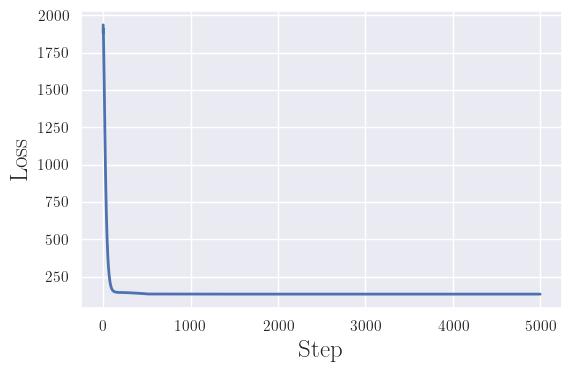

/tmp/ipykernel_454774/3255568261.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Running experiment for noise_scale=1 and prior_scale=1


/home/shikai_q/anaconda3/envs/fspace/lib/python3.10/site-packages/distrax/_src/utils/conversion.py:143: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(jnp.float_)
100%|██████████| 5000/5000 [06:52<00:00, 12.12it/s]
/home/shikai_q/anaconda3/envs/fspace/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shikai_q/anaconda3/envs/fspace/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(b

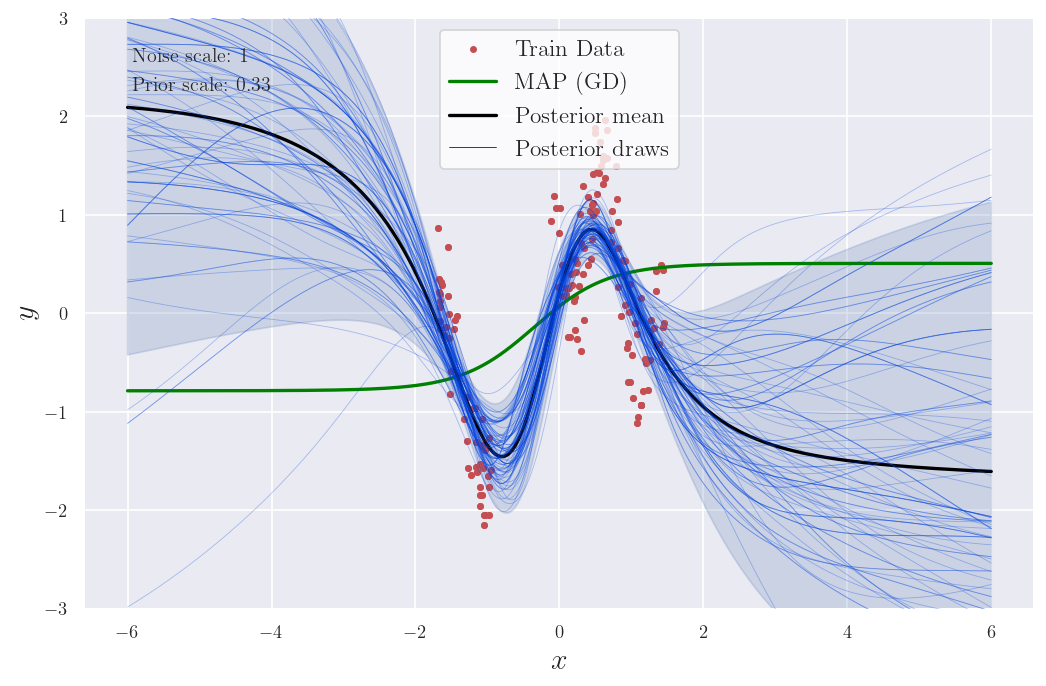

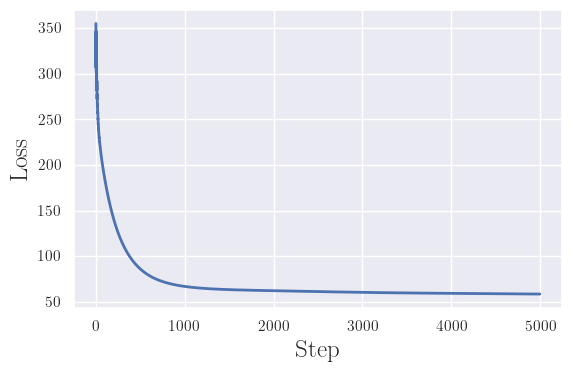

/tmp/ipykernel_454774/3255568261.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Running experiment for noise_scale=1 and prior_scale=3.3


/home/shikai_q/anaconda3/envs/fspace/lib/python3.10/site-packages/distrax/_src/utils/conversion.py:143: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(jnp.float_)
100%|██████████| 5000/5000 [06:44<00:00, 12.36it/s]


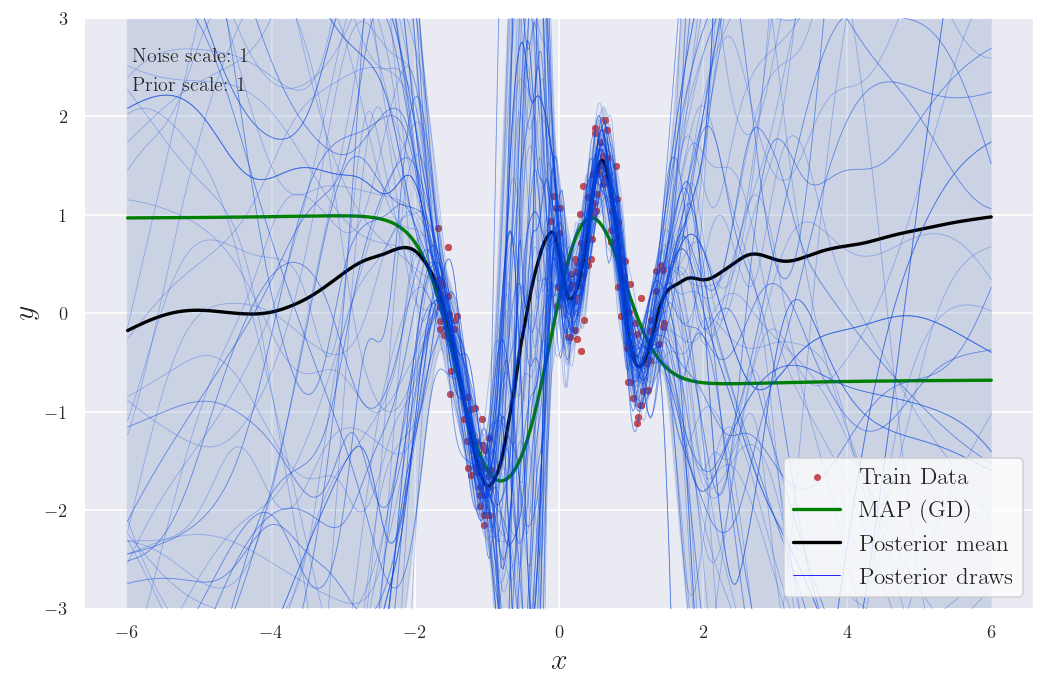

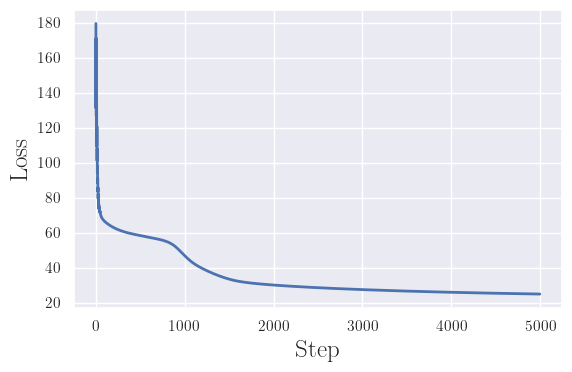

Running experiment for noise_scale=0.33 and prior_scale=0.33


100%|██████████| 5000/5000 [06:44<00:00, 12.36it/s]


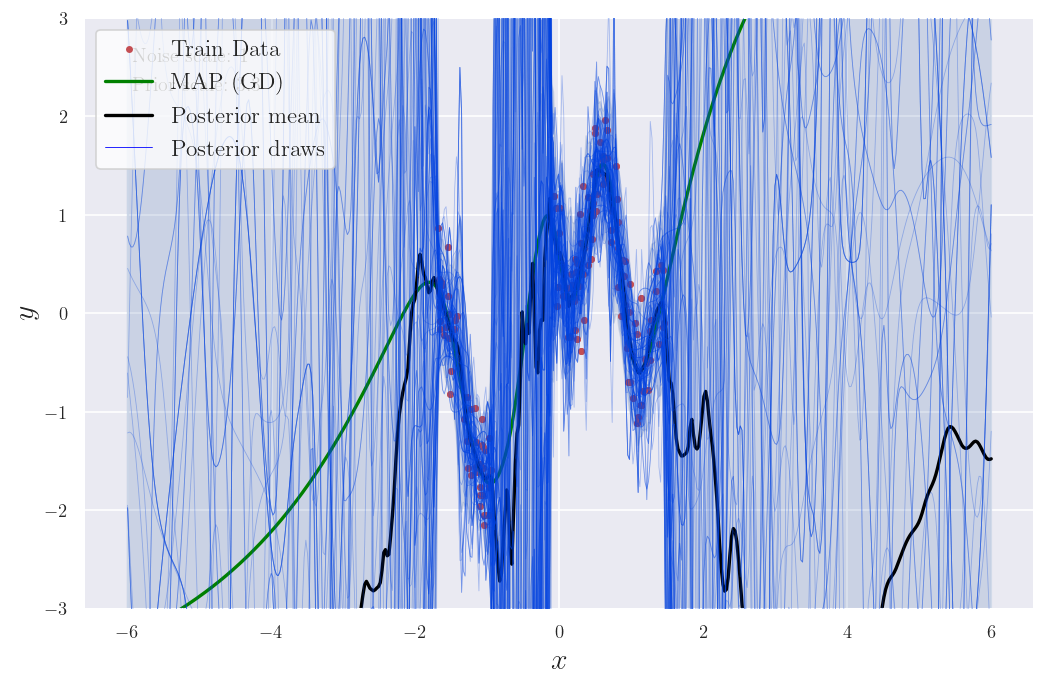

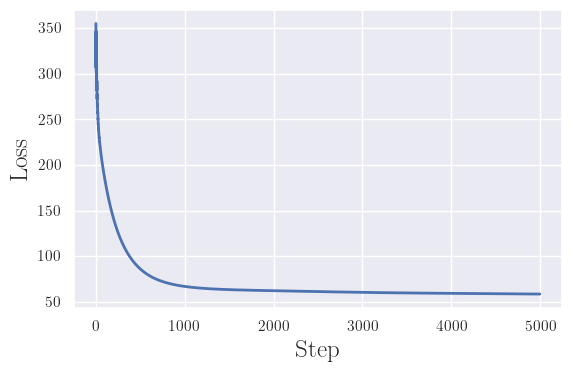

Running experiment for noise_scale=0.33 and prior_scale=1


100%|██████████| 5000/5000 [06:48<00:00, 12.24it/s]


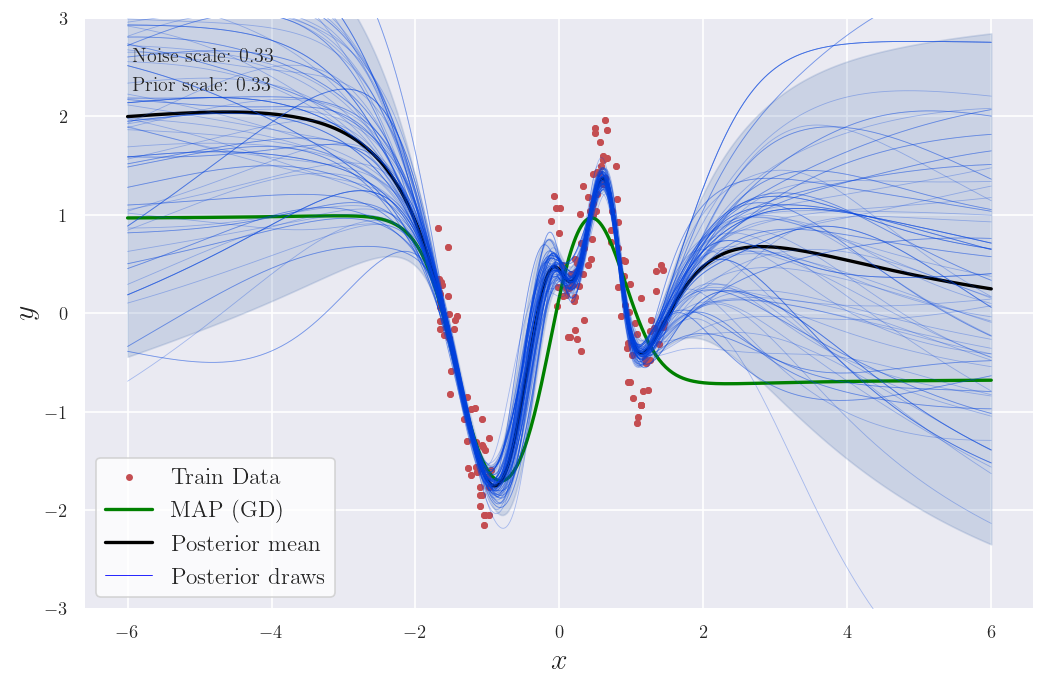

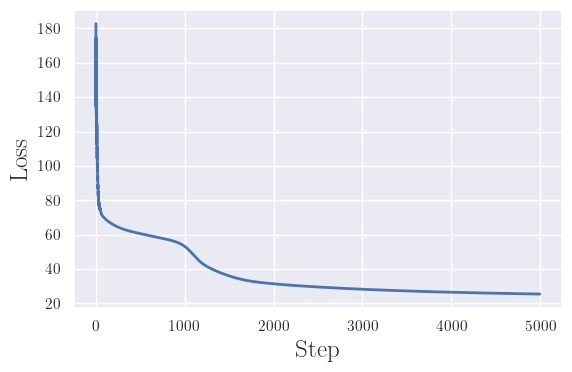

Running experiment for noise_scale=0.33 and prior_scale=3.3


100%|██████████| 5000/5000 [06:48<00:00, 12.23it/s]


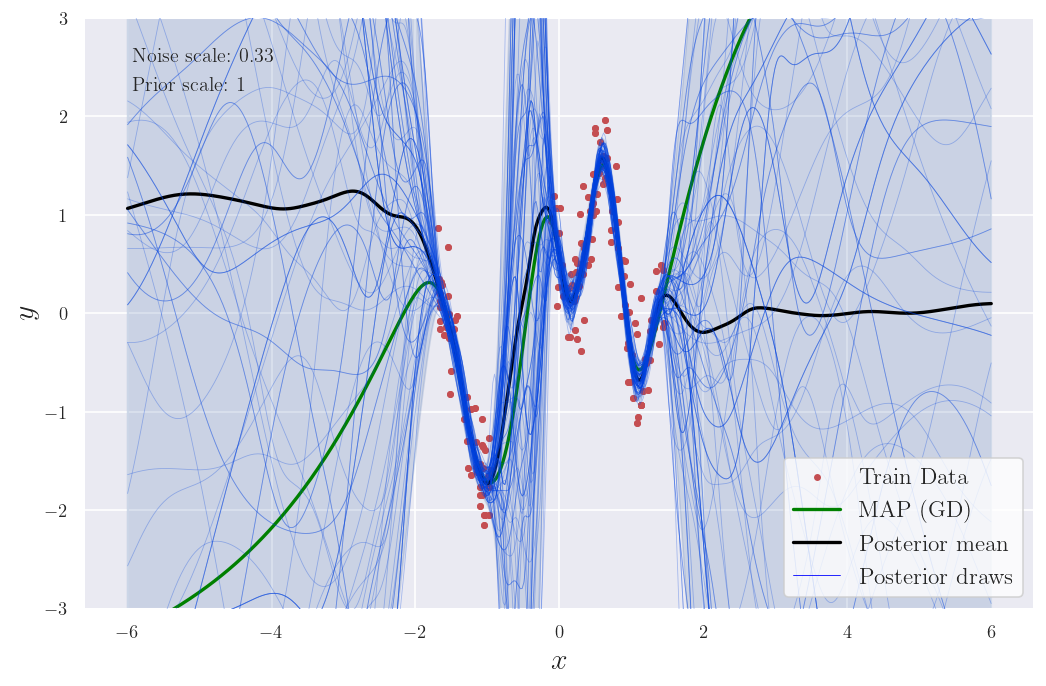

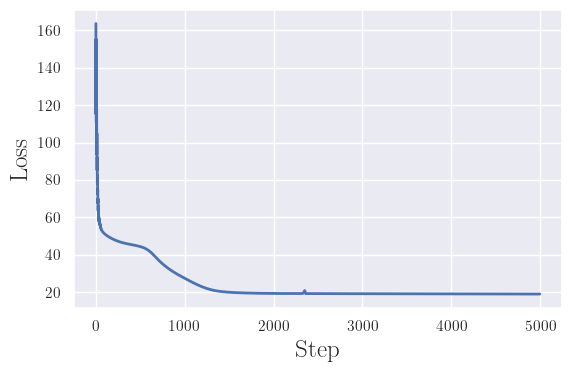

Running experiment for noise_scale=0.1 and prior_scale=0.33


100%|██████████| 5000/5000 [06:51<00:00, 12.15it/s]


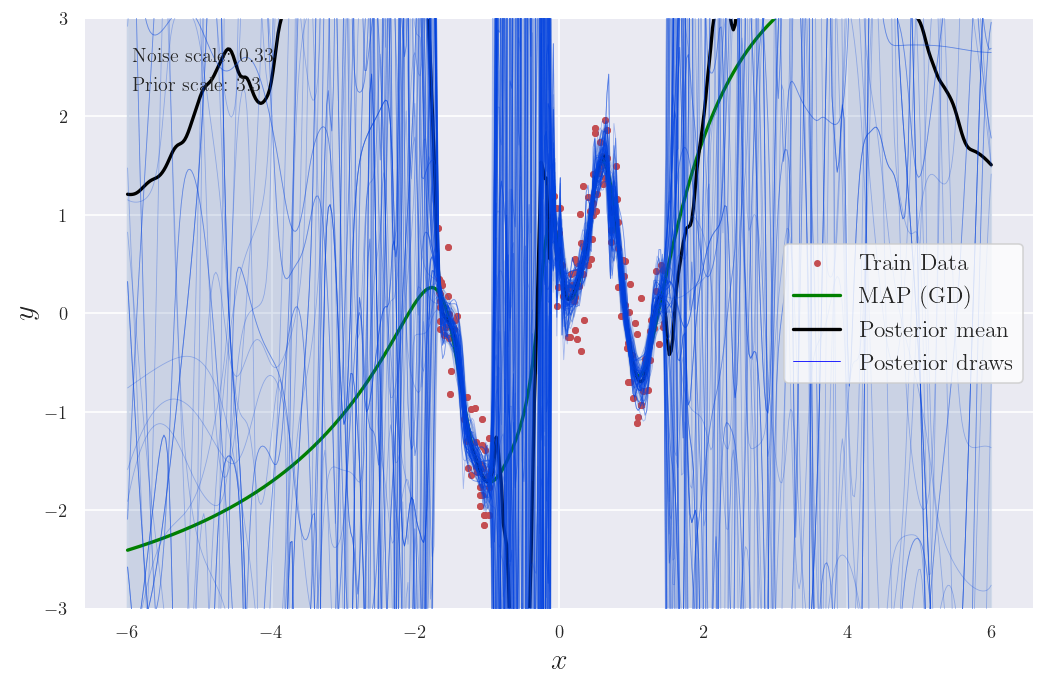

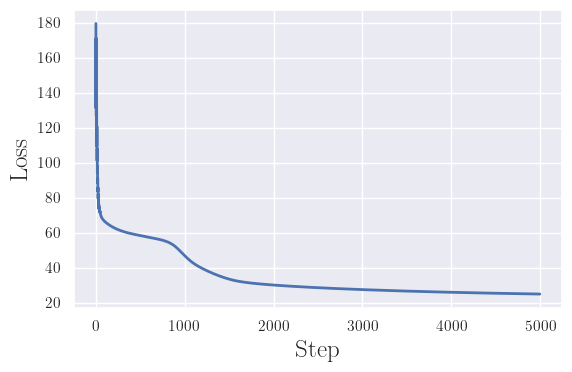

Running experiment for noise_scale=0.1 and prior_scale=1


100%|██████████| 5000/5000 [06:49<00:00, 12.22it/s]


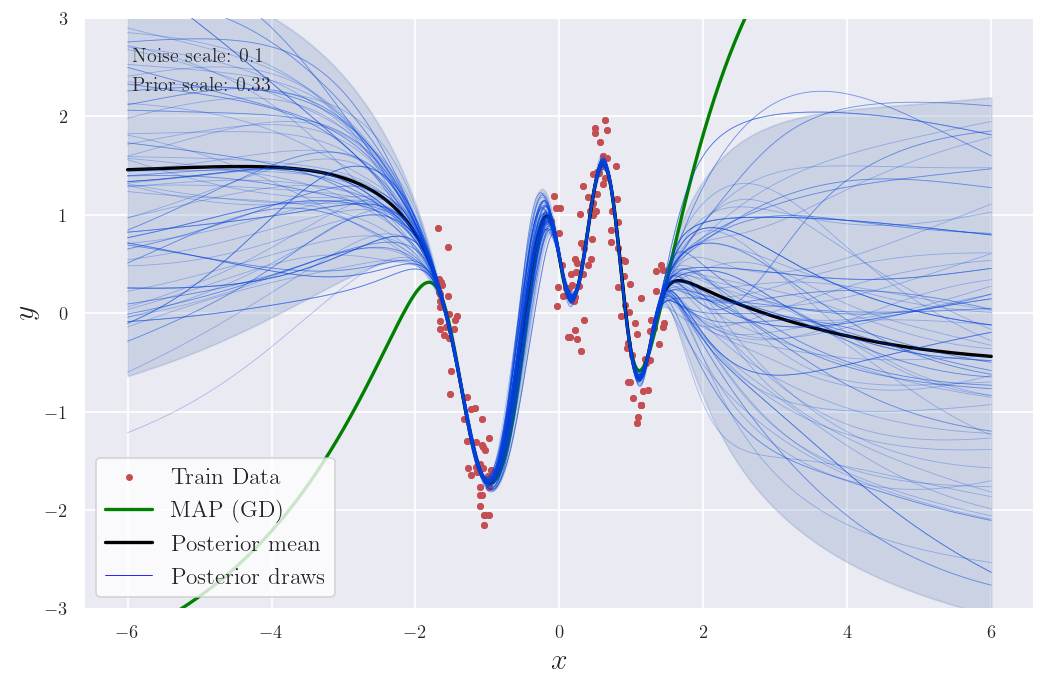

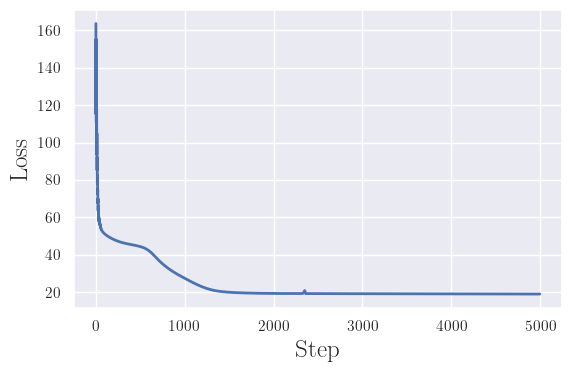

Running experiment for noise_scale=0.1 and prior_scale=3.3


100%|██████████| 5000/5000 [06:52<00:00, 12.11it/s]


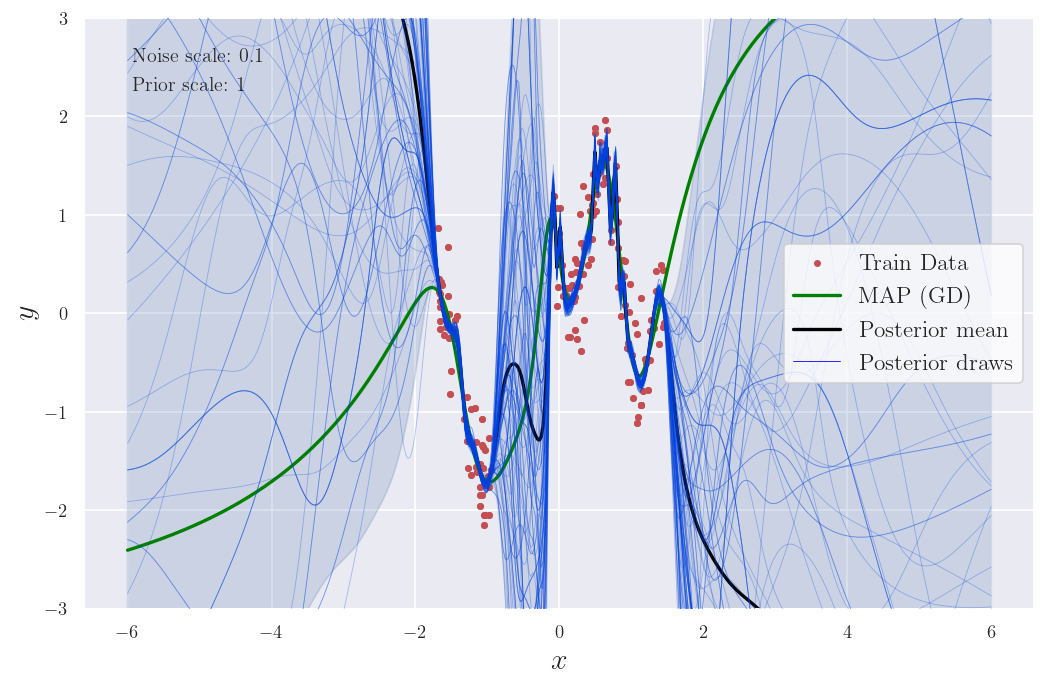

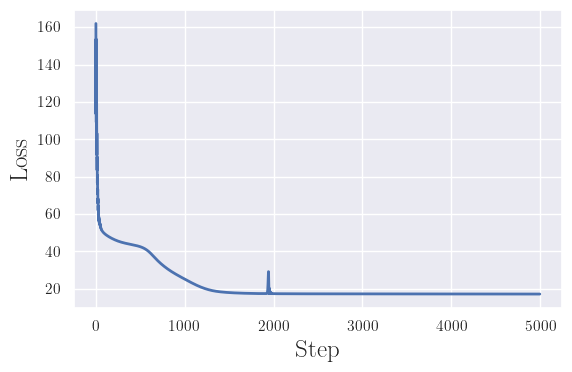

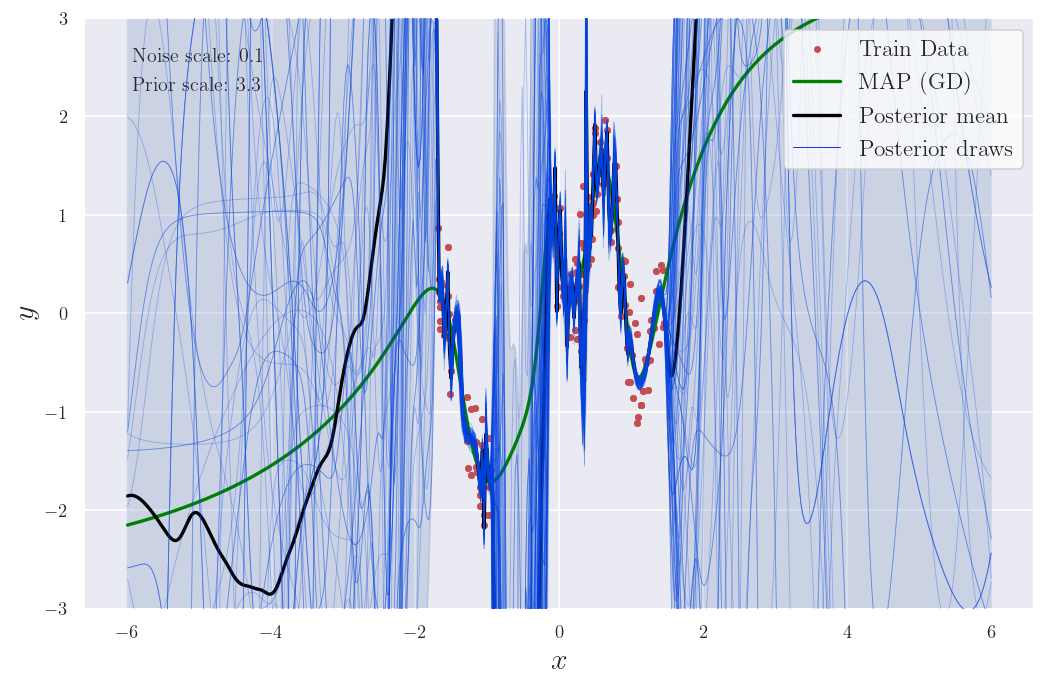

In [11]:
# model
noise_scales = [1, 0.33, 0.1]
prior_scales = [0.33, 1, 3.3]

# HMC hyper
n_warmup = 500
num_samples = 100

# SGD hyper
lr = 1e-4
momentum = .9
n_steps = 5000

plots_dir = 'plots/1012'
# mkdir if needed
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

for noise_scale in noise_scales:
    for prior_scale in prior_scales:
        print(f'Running experiment for noise_scale={noise_scale} and prior_scale={prior_scale}')
        run_experiment(noise_scale, prior_scale, n_warmup, num_samples, lr, momentum, n_steps, plots_dir)